- The LT5560EDD#PBF seems like it would be a good option, it doesn't seem to have a minimum input frequency and the maximum input freq. is 4 GHz, which is far more than what we need.
- For simplicity, let's make everything single ended to avoid the need for a balun.
- I assume the LO has to be impedance matched. 
- It seems like AFC is no longer used since crystals provide a very stable frequency, as seen on both wikipedia and this link: https://www.quora.com/What-is-frequency-drift-in-an-FM-receiver. Most LOs today use digitally synthesized signals connected to crystals. These are known as "frequency synthesizers" - they are able to generate many different stable frequencies using a single reference frequency from a crystal.
- This seems like a really good option: https://www.digikey.com/en/products/detail/skyworks-solutions-inc/SI5351A-B-GTR/4069612. Unlike the previous one, it uses a crystal, so the frequency error is close to 0.
    - However, it seems like it can only divide by multiples of 2, so it wouldn't work for our purposes since we need to change the LO frequency from 77 MHz to 98 MHz.
- This might be a better option: https://www.digikey.com/en/products/detail/analog-devices-inc/ADF4169CCPZ/5441070
- PLLs also don't drift because any error is compensated for in the PLL.
- How to change both the input filter and the LO freq. at the same time?
    - Use this thing called a Dual Gang Capacitor, essentially changes two caps at the same time with one knob.
- In a high-side mixer, the FM modulated signal will essentially be inverted. This is because fIF = |fRF - fLO|, so if fRF increases then fRF becomes closer to fLO, so fIF decreases. This doesn't really matter (not completely sure about this), as long as we're aware that it's mirrored. https://www.edaboard.com/threads/high-side-injection-and-low-side-injection-in-mixer.125131/
- Does a clock generator work (square wave) or do I need a sine wave for the LO?
    - There seems to be a variety of different opinions online. https://www.reddit.com/r/rfelectronics/comments/12wqxvw/rf_mixer_square_wave_lo/
    - It seems like a square wave is practically hard to produce, but could be beneficial. Some people are also saying that the higher order harmonics could be aliased down to the IF, others are saying that a square wave is the ideal mixer input. For now, I'm going to go with a square wave.
- The mixer mentioned above says either low-side or high-side mixing can be used. Let's use low-side mixing so that the signal is not inverted. This means that fLO = fRF - fIF = fRF - 10.7MHz.
- If we're using the ADF4169CCPZ above, we'll need to write to the registers to control the input, which means we'll need a microcontroller to do that, as well as read the tuned capacitance of the input filter.
    - It doesn't explicitly mention it, but looks like it uses I2C since it has a clock and data line. If not, we can just manually code the protocol instead of using an I2C library.
- We can use the same 0.1 uF cap we used as a blocking cap for the HF amp as a decoupling cap here since it has a very high self-resonant frequency of 6 GHz.
- The INT multiplier for the reference frequency is from 23 to 4095. If we want a LO signal of 77 MHz to 97 MHz, then we can potentially use a reference frequency around 1 MHz.
- Let's use this CMOS crystal oscillator: https://www.digikey.com/en/products/detail/analog-devices-inc-maxim-integrated/MAX7375AXR105-T/1520107
- It seems like we can just use a PLL with a VCO built in instead. This seems like a good option: https://www.digikey.com/en/products/detail/analog-devices-inc/ADF4360-9BCPZRL7/2043337
    - Actually, it seems like this is an integer-N PLL, but we need a fractional N PLL.
- Even if we find another PLL with an integrated VCO, it seems we'll still need an external loop filter, so might as well stick with the original with an external VCO - looks like we're back to the ADF4169CCPZ.


PLL (Phase Locked Loop)

- PLLs typically work as follows:
- 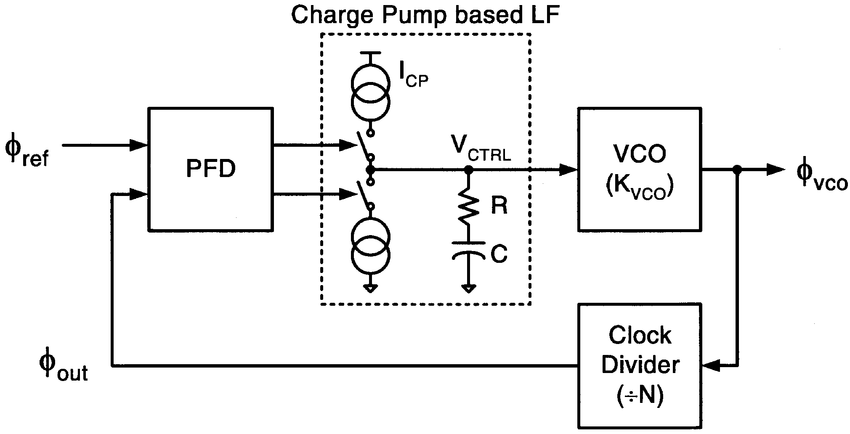

- Assuming that the input is a square wave and the PFD is a digital circuit, a simple PFD can be implemented using an XOR gate that is high for the portion of time when the reference signal and the output signal are different. If the two signals are 1 degree out of phase, this will result in a pulse with a width of 1/180 the period of the signals.
- The charge pump performs integration, which can correct for both phase and freq. errors, since freq. is the derivative of phase.
- The charge pump for the ADF4169 outputs a current, which is converted to a voltage by the loop filter. https://electronics.stackexchange.com/questions/301056/loop-filter-of-pll
- Since a LPF also performs integration, a charge pump can technically replace a LPF with a capacitor.

This seems like a good VCO: https://www.digikey.com/en/products/detail/analog-devices-inc-maxim-integrated/MAX2623EUA-T/1938007

- TODO: replace RC Loop filter with actual res and cap values based on stackexchange link above.

Loop Filter Design 

- Following this link, second order loop filter design:
- https://www.renesas.cn/cn/zh/document/apn/pll-loop-filter-design-and-fine-tuning
1. Desired loop bandwidth must satisfy Fpd/Fc >> 20, where Fpd is the freq. to the phase detector = the frequency of our ref signal, which is 1 MHz. This means that Fc << 1 MHz/20 = 50 kHz. Let's set the loop bandwidth to 10 kHz.
2. Rs = (2*pi*fc*N)/(Icp*KVco). N varies between 77 and 97 -> Let's choose 87 as the nominal value. According to the datasheet, it is best to start with 2.5 mA for the charge pump current. The VCO gain is given by 6.2 MHz/V. Therefore, Rs = (2*3.1415*10000*87)/(2.5*10^-3*6.2*10^6) = 352.658709677 ohms. 
3. Cs = alpha/(2*pi*fc*Rc), where alpha is the ratio of the loop bandwidth to the zero frequency. It's recommended that alpha > 3, so let's do alpha = 5. That gives Cs = 5/(2*3.1415*10000*352.6587) = 225.656757 nF.
4. Cp = Cs/(alpha*Beta), where beta is the ratio between pole freq. and bandwidth. It's recommended that beta > 3, so let's choose beta = 5. That gives Cp = (225.656757*10^-9)/(5*5) = 9.02627028 nF.
5. The maximum phase margin is given by arctan((b-1)/(2*sqrt(b))), where b = 1 + Cs/Cp. In our case, b = 1 + 225.656757/9.02627028 = 26, so the phase margin = 67.80839366845 degrees > 50 degrees -> the PLL is stable.

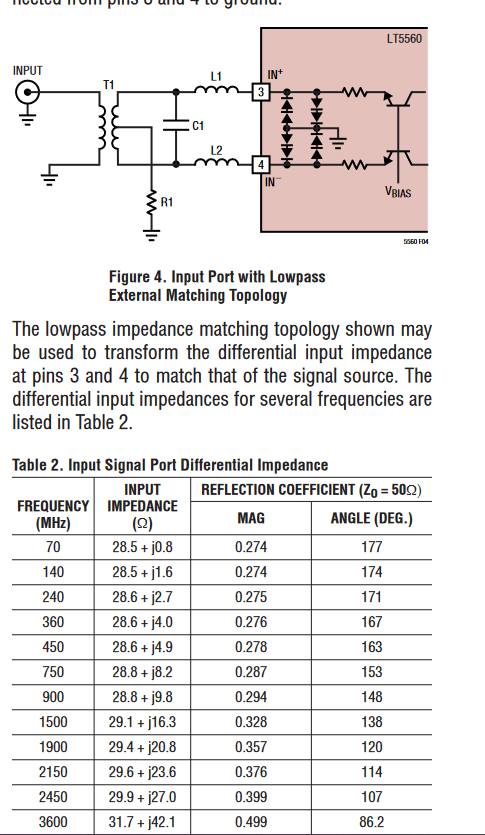

For the mixer, the input impedance varies between approximately 28.5 + j to 28.5 + 1.4j for the frequencies of 88 MHz to 108 MHz based on this table. 

Since we're operating at a nominal frequency of 98 MHz, the input impedance = 28.5 + 1.12j. Q = sqrt(Rs/Rl - 1) = sqrt(50/28.5 - 1) = 0.86855395049. Xc = Rs/Q = 50/0.86855395049 = 57.5669478814 ohms = 1/(2*pi*98M*C)=> C = 1/(2*pi*98M*57.5669478814) = 28.211154 pF. Xl = Rl/Q = 28.5/0.86855395049 = 32.8131602924 ohms. Xext = Xl - Xint = 32.8131602924 - 1.12 = 31.6931602924 ohms/2 = 15.8465801462 ohms per inductor = 2*pi*98M*Lext => Lext = 25.7353221 nH.